
![alt text](https://image.slidesharecdn.com/azuremltraining-180519131910/95/azure-ml-training-deep-dive-15-638.jpg?cb=1526736147)





1 - Data Collection

 
2 - Data Preparation


3 - Choose a Model

 
4 - Train the Model

 
5 - Evaluate the Model

 
6 - Parameter Tuning

 
7 - Make Predictions

##1 - Data Collection

The first step in the Machine Learning process is getting data.

The quantity & quality of your data dictate how accurate our model is
The outcome of this step is generally a representation of data (Guo simplifies to specifying a table) which we will use for training

This process depends on your project and data type. For example, you can collect real-time data from an IoT system. 
Data can scrapped from websites or records can be downloaded.
Static data from an existing database.
You can also use data from internet repositories sites such as Kaggle and others.

 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.style.use('ggplot')

In [6]:
# combine train and test set.
train = pd.read_csv( "/content/train.csv")
test = pd.read_csv( "/content/test.csv")
full=pd.concat([train,test],ignore_index=True)

In [7]:
full.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1       0.0       3  ...   7.2500   NaN         S
1            2       1.0       1  ...  71.2833   C85         C
2            3       1.0       3  ...   7.9250   NaN         S
3            4       1.0       1  ...  53.1000  C123         S
4            5       0.0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

# 2 - Data Preparation

Wrangle data and prepare it for training
Clean that which may require it (remove duplicates, correct errors, deal with missing values, normalization, data type conversions, etc.)
Randomize data, which erases the effects of the particular order in which we collected and/or otherwise prepared our data
Visualize data to help detect relevant relationships between variables or class imbalances (bias alert!), or perform other exploratory analysis
Split into training and evaluation sets

In [10]:
full.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

__The 'Age', 'Cabin', 'Embarked', 'Fare' columns have missing values. First we fill the missing 'Embarked' with the mode.__

In [11]:
full.Embarked.mode()

0    S
dtype: object

In [12]:
full['Embarked'].fillna('S',inplace=True)

__Since 'Fare' is mainly related to 'Pclass', we should check which class this person belongs to.__

In [13]:
full[full.Fare.isnull()]

PassengerId  Survived  Pclass  ... Fare Cabin  Embarked
1043         1044       NaN       3  ...  NaN   NaN         S

[1 rows x 12 columns]

__It's a passenger from Pclass 3, so we'll fill the missing value with the median fare of Pclass 3.__

In [14]:
full.Fare.fillna(full[full.Pclass==3]['Fare'].median(),inplace=True)

**There are a lot of missing values in 'Cabin', maybe there is difference between the survival rate of people who has Cabin number and those who hasn't.**

In [15]:
full.loc[full.Cabin.notnull(),'Cabin']=1
full.loc[full.Cabin.isnull(),'Cabin']=0

In [16]:
full.Cabin.isnull().sum()

0

Text(0.5, 1.0, 'Survival Rate')

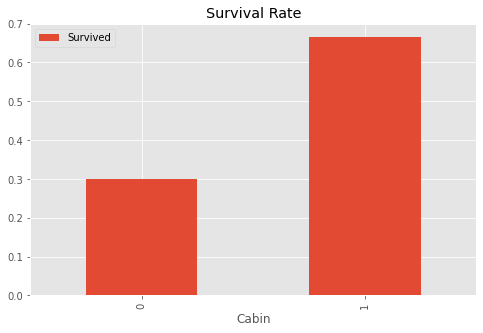

In [17]:
pd.pivot_table(full,index=['Cabin'],values=['Survived']).plot.bar(figsize=(8,5))
plt.title('Survival Rate')

__We can also plot the count of 'Cabin' to see some patterns.__

In [18]:
cabin=pd.crosstab(full.Cabin,full.Survived)
cabin.rename(index={0:'no cabin',1:'cabin'},columns={0.0:'Dead',1.0:'Survived'},inplace=True)
cabin

Survived  Dead  Survived
Cabin                   
no cabin   481       206
cabin       68       136

In [19]:
cabin.plot.bar(figsize=(8,5))
plt.xticks(rotation=0,size='xx-large')
plt.title('Survived Count')
plt.xlabel('')
plt.legend()

__From the plot, we can conclude that there is far more chance for a passenger to survive if we know his/her 'Cabin'.__

### Extract Title from 'Name'

In [20]:
full['Title']=full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [21]:
full.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Ms                2
Mlle              2
Lady              1
Jonkheer          1
Dona              1
the Countess      1
Mme               1
Don               1
Sir               1
Capt              1
Name: Title, dtype: int64

In [22]:
pd.crosstab(full.Title,full.Sex)

Sex           female  male
Title                     
Capt               0     1
Col                0     4
Don                0     1
Dona               1     0
Dr                 1     7
Jonkheer           0     1
Lady               1     0
Major              0     2
Master             0    61
Miss             260     0
Mlle               2     0
Mme                1     0
Mr                 0   757
Mrs              197     0
Ms                 2     0
Rev                0     8
Sir                0     1
the Countess       1     0

__All the 'Title' belongs to one kind of gender except for 'Dr'.__

In [23]:
full[(full.Title=='Dr')&(full.Sex=='female')]

PassengerId  Survived  Pclass  ... Cabin Embarked  Title
796          797       1.0       1  ...     1        S     Dr

[1 rows x 13 columns]

__So the PassengerId of the female 'Dr' is '797'. Then we map the 'Title'.__

In [24]:
nn={'Capt':'Rareman', 'Col':'Rareman','Don':'Rareman','Dona':'Rarewoman',
    'Dr':'Rareman','Jonkheer':'Rareman','Lady':'Rarewoman','Major':'Rareman',
    'Master':'Master','Miss':'Miss','Mlle':'Rarewoman','Mme':'Rarewoman',
    'Mr':'Mr','Mrs':'Mrs','Ms':'Rarewoman','Rev':'Mr','Sir':'Rareman',
    'the Countess':'Rarewoman'}

In [25]:
full.Title=full.Title.map(nn)

In [26]:
# assign the female 'Dr' to 'Rarewoman'
full.loc[full.PassengerId==797,'Title']='Rarewoman'

In [27]:
full.Title.value_counts()

Mr           765
Miss         260
Mrs          197
Master        61
Rareman       17
Rarewoman      9
Name: Title, dtype: int64

In [28]:
full[full.Title=='Master']['Sex'].value_counts()

male    61
Name: Sex, dtype: int64

In [29]:
full[full.Title=='Master']['Age'].describe()

count    53.000000
mean      5.482642
std       4.161554
min       0.330000
25%       2.000000
50%       4.000000
75%       9.000000
max      14.500000
Name: Age, dtype: float64

In [30]:
full[full.Title=='Miss']['Age'].describe()

count    210.000000
mean      21.774238
std       12.249077
min        0.170000
25%       15.000000
50%       22.000000
75%       30.000000
max       63.000000
Name: Age, dtype: float64

+ __'Master' mainly stands for little boy, but we also want to find little girl. Because children tend to have higher survival rate.__

+ __For the 'Miss' with a Age record, we can simply determine whether a 'Miss' is a little girl by her age.__

+ __For the 'Miss' with no Age record, we use (Parch!=0). Since if it's a little girl, she was very likely to be accompanied by parents.__

We'll create a function to filter the girls. The function can't be used if 'Age' is Nan, so first we fill the missing values with '999'.

In [31]:
full.Age.fillna(999,inplace=True)

In [32]:
def girl(aa):
    if (aa.Age!=999)&(aa.Title=='Miss')&(aa.Age<=14):
        return 'Girl'
    elif (aa.Age==999)&(aa.Title=='Miss')&(aa.Parch!=0):
        return 'Girl'
    else:
        return aa.Title

In [33]:
full['Title']=full.apply(girl,axis=1)

In [34]:
full.Title.value_counts()

Mr           765
Miss         201
Mrs          197
Master        61
Girl          59
Rareman       17
Rarewoman      9
Name: Title, dtype: int64

__Next we fill the missing 'Age' according to their 'Title'.__

In [35]:
full[full.Age==999]['Age'].value_counts()

999.0    263
Name: Age, dtype: int64

In [36]:
Tit=['Mr','Miss','Mrs','Master','Girl','Rareman','Rarewoman']
for i in Tit:
    full.loc[(full.Age==999)&(full.Title==i),'Age']=full.loc[full.Title==i,'Age'].median()

In [37]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


### Finally, there is no missing value now!!!

### Exploratory Visualization

In [38]:
full.head()

PassengerId  Survived  Pclass  ... Cabin Embarked  Title
0            1       0.0       3  ...     0        S     Mr
1            2       1.0       1  ...     1        C    Mrs
2            3       1.0       3  ...     0        S   Miss
3            4       1.0       1  ...     1        S    Mrs
4            5       0.0       3  ...     0        S     Mr

[5 rows x 13 columns]

__Let's first check whether the Age of each Title is reasonable.__

In [39]:
full.groupby(['Title'])[['Age','Title']].mean().plot(kind='bar',figsize=(8,5))
plt.xticks(rotation=0)
plt.show()

__As we can see, female has a much larger survival rate than male.__

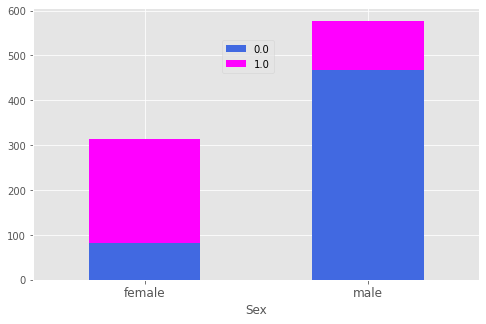

In [40]:
pd.crosstab(full.Sex,full.Survived).plot.bar(stacked=True,figsize=(8,5),color=['#4169E1','#FF00FF'])
plt.xticks(rotation=0,size='large')
plt.legend(bbox_to_anchor=(0.55,0.9))

__ We can also check the relationship between 'Age' and 'Survived'.__

In [41]:
agehist=pd.concat([full[full.Survived==1]['Age'],full[full.Survived==0]['Age']],axis=1)
agehist.columns=['Survived','Dead']
agehist.head()

Survived  Dead
0       NaN  22.0
1      38.0   NaN
2      26.0   NaN
3      35.0   NaN
4       NaN  35.0

In [42]:
agehist.plot(kind='hist',bins=30,figsize=(15,8),alpha=0.3)

In [43]:
farehist=pd.concat([full[full.Survived==1]['Fare'],full[full.Survived==0]['Fare']],axis=1)
farehist.columns=['Survived','Dead']
farehist.head()

Survived  Dead
0       NaN  7.25
1   71.2833   NaN
2    7.9250   NaN
3   53.1000   NaN
4       NaN  8.05

In [44]:
farehist.plot.hist(bins=30,figsize=(15,8),alpha=0.3,stacked=True,color=['blue','red'])

__People with high 'Fare' are more likely to survive, though most 'Fare' are under 100.__

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

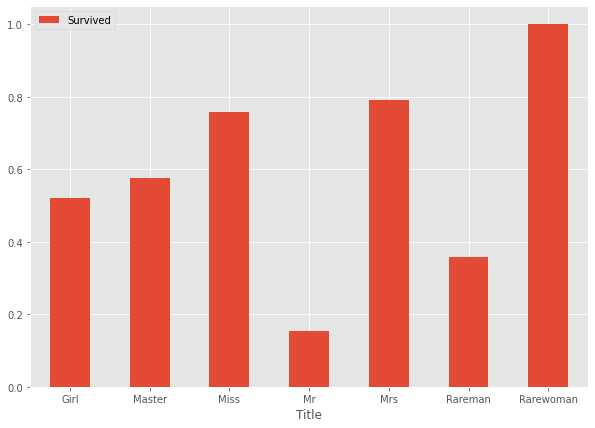

In [46]:
full.groupby(['Title'])[['Title','Survived']].mean().plot(kind='bar',figsize=(10,7))
plt.xticks(rotation=0)

__The 'Rarewoman' has 100% survival rate, that's amazing!!__

__It's natural to assume that 'Pclass' also plays a big part, as we can see from the plot below. The females in class 3 have a survival rate of about 50%, while survival rateof females from class1/2 are much higher.__

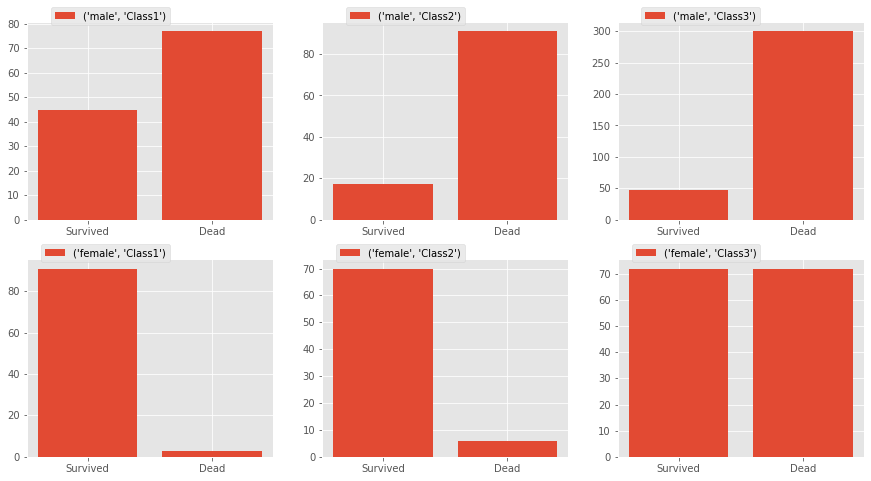

In [47]:
fig,axes=plt.subplots(2,3,figsize=(15,8))
Sex1=['male','female']
for i,ax in zip(Sex1,axes):
    for j,pp in zip(range(1,4),ax):
        PclassSex=full[(full.Sex==i)&(full.Pclass==j)]['Survived'].value_counts().sort_index(ascending=False)
        pp.bar(range(len(PclassSex)),PclassSex,label=(i,'Class'+str(j)))
        pp.set_xticks((0,1))
        pp.set_xticklabels(('Survived','Dead'))
        pp.legend(bbox_to_anchor=(0.6,1.1))

# 3 - Choose a Model

Different algorithms are for different tasks; choose the right one

![alt text](https://blogs.sas.com/content/subconsciousmusings/files/2017/04/machine-learning-cheet-sheet.png)

### Basic Modeling & Evaluation

In [63]:
predictors=['Cabin','Embarked','Parch','Pclass','Sex','SibSp','Title','Age','Fare']

In [64]:
# convert categorical variables to numerical variables
full_dummies=pd.get_dummies(full[predictors])

In [65]:
full_dummies.head()

Parch  Pclass  SibSp  ...  Title_Mrs  Title_Rareman  Title_Rarewoman
0      0       3      1  ...          0              0                0
1      0       1      1  ...          1              0                0
2      0       3      0  ...          0              0                0
3      0       1      1  ...          1              0                0
4      0       3      0  ...          0              0                0

[5 rows x 19 columns]

# 4 - Train Model

This step is where the magic happens! The data set connects to an algorithm, and the algorithm leverages sophisticated mathematical modeling to learn and develop predictions.

These algorithms commonly fall into one of three categories:

#### Binary – Classify into two categories
#### Classification – Classify into many categories
#### Regression – Predict a numeric

The goal of training is to answer a question or make a prediction correctly as often as possible
Linear regression example: algorithm would need to learn values for m (or W) and b (x is input, y is output)
Each iteration of process is a training step

__We choose 7 models and use 5-folds cross-calidation to evaluate these models.__

Models include:

+ k-Nearest Neighbors
+ Logistic Regression
+ Naive Bayes classifier
+ Decision Tree
+ Random Forrest
+ Gradient Boosting Decision Tree
+ Support Vector Machine

In [66]:
from sklearn.model_selection import cross_val_score

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [68]:
models=[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),
       GradientBoostingClassifier(),SVC()]

In [69]:
full.shape,full_dummies.shape

((1309, 15), (1309, 19))

In [70]:
X=full_dummies[:891]
y=full.Survived[:891]
test_X=full_dummies[891:]

__As some algorithms such as KNN and SVM are sensitive to the scaling of the data, here we also apply standard-scaling to the data.__

In [71]:
from sklearn.preprocessing import StandardScaler

In [72]:
scaler=StandardScaler()
X_scaled=scaler.fit(X).transform(X)
test_X_scaled=scaler.fit(X).transform(test_X)

In [73]:
# evaluate models by using cross-validation
names=['KNN','LR','NB','Tree','RF','GDBT','SVM']
for name, model in zip(names,models):
    score=cross_val_score(model,X,y,cv=5)
    print("{}:{},{}".format(name,score.mean(),score))

KNN:0.6992844140355283,[0.63687151 0.69101124 0.70224719 0.73595506 0.73033708]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR:0.8271420500910175,[0.84357542 0.80898876 0.79775281 0.81460674 0.87078652]
NB:0.804670139978658,[0.84357542 0.80898876 0.78651685 0.7752809  0.80898876]
Tree:0.7755445358106835,[0.76536313 0.76966292 0.79775281 0.73595506 0.80898876]
RF:0.8091959073504489,[0.81564246 0.79213483 0.83707865 0.76404494 0.83707865]
GDBT:0.8361370912058252,[0.83798883 0.79775281 0.86516854 0.80898876 0.87078652]
SVM:0.6723746155294709,[0.58659218 0.71348315 0.68539326 0.68539326 0.69101124]


In [74]:
# used scaled data
names=['KNN','LR','NB','Tree','RF','GDBT','SVM']
for name, model in zip(names,models):
    score=cross_val_score(model,X_scaled,y,cv=5)
    print("{}:{},{}".format(name,score.mean(),score))

KNN:0.8047015253279769,[0.81564246 0.7752809  0.84269663 0.7752809  0.81460674]
LR:0.8271483271608812,[0.83798883 0.80337079 0.79775281 0.81460674 0.88202247]
NB:0.7418617789215994,[0.74301676 0.76404494 0.71910112 0.70786517 0.7752809 ]
Tree:0.7766681313163015,[0.76536313 0.7752809  0.80898876 0.7247191  0.80898876]
RF:0.8103195028560668,[0.81564246 0.79213483 0.84269663 0.75280899 0.84831461]
GDBT:0.8361370912058252,[0.83798883 0.79775281 0.86516854 0.80898876 0.87078652]
SVM:0.8226476680685456,[0.84357542 0.82022472 0.82022472 0.7752809  0.85393258]


__'k-Nearest Neighbors', 'Support Vector Machine' perform much better on scaled data__

**Then we use (feature importances) in GradientBoostingClassifier to see which features are important.**

In [75]:
model=GradientBoostingClassifier()

In [76]:
model.fit(X,y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# 5 - Evaluate the Model

Uses some metric or combination of metrics to "measure" objective performance of model
Test the model against previously unseen data
This unseen data is meant to be somewhat representative of model performance in the real world, but still helps tune the model (as opposed to test data, which does not)
Good train/eval split? 80/20, 70/30, or similar, depending on domain, data availability, dataset particulars, etc.

In [77]:
model.feature_importances_

array([0.00383205, 0.12306636, 0.01710372, 0.09123622, 0.18020366,
       0.01694527, 0.01181936, 0.00213141, 0.00117621, 0.01048866,
       0.00157287, 0.00100696, 0.00159595, 0.00630039, 0.00151124,
       0.49264412, 0.00156245, 0.03580311, 0.        ])

In [78]:
X.columns

Index(['Parch', 'Pclass', 'SibSp', 'Age', 'Fare', 'Cabin_0', 'Cabin_1',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title_Girl', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rareman', 'Title_Rarewoman'],
      dtype='object')

In [79]:
fi=pd.DataFrame({'importance':model.feature_importances_},index=X.columns)

In [80]:
fi.sort_values('importance',ascending=False)

importance
Title_Mr           0.492644
Fare               0.180204
Pclass             0.123066
Age                0.091236
Title_Rareman      0.035803
SibSp              0.017104
Cabin_0            0.016945
Cabin_1            0.011819
Embarked_S         0.010489
Title_Master       0.006300
Parch              0.003832
Embarked_C         0.002131
Title_Girl         0.001596
Sex_female         0.001573
Title_Mrs          0.001562
Title_Miss         0.001511
Embarked_Q         0.001176
Sex_male           0.001007
Title_Rarewoman    0.000000

Text(0.5, 1.0, 'Feature Importance')

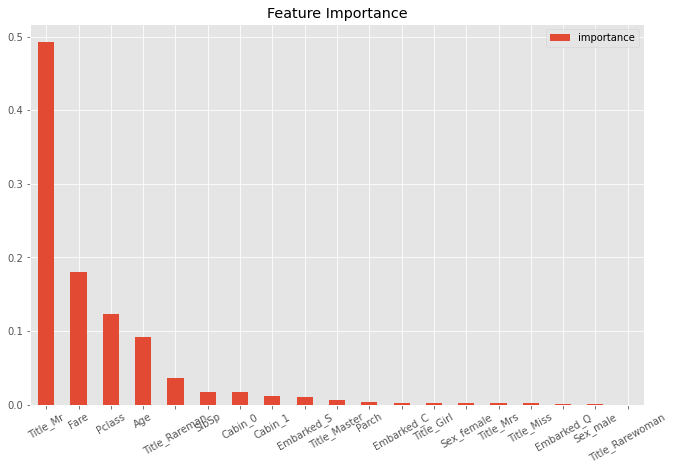

In [81]:
fi.sort_values('importance',ascending=False).plot.bar(figsize=(11,7))
plt.xticks(rotation=30)
plt.title('Feature Importance',size='x-large')

__Based on the bar plot, 'TPP','Fare','Age' are the most important.__

**Now let's think through this problem in another way. Our goal here is to improve the overall accuracy. This is equivalent to minimizing the misclassified observations. So if all the misclassified observations are found, maybe we can see the pattern and generate some new features.**

**Again we use cross-validation to search for the miscalssified observations**

In [82]:
from sklearn.model_selection import KFold

In [83]:
kf=KFold(n_splits=10,random_state=1)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [84]:
kf.get_n_splits(X)

10

In [85]:
print(kf)

KFold(n_splits=10, random_state=1, shuffle=False)


In [87]:
# extract the indices of misclassified observations
rr=[]
for train_index, val_index in kf.split(X):
    pred=model.fit(X.loc[train_index],y[train_index]).predict(X.loc[val_index])
    rr.append(y[val_index][pred!=y[val_index]].index.values)

In [88]:
rr

[array([ 2, 17, 18, 21, 23, 25, 30, 36, 38, 40, 41, 49, 55, 68, 74, 79, 81,
        85]),
 array([106, 107, 109, 111, 114, 127, 137, 139, 140, 141, 146, 169, 177]),
 array([186, 187, 192, 199, 204, 205, 207, 209, 220, 224, 226, 233, 235,
        240, 245, 246, 248, 251, 252, 261, 264, 267]),
 array([271, 279, 283, 286, 288, 297, 301, 312, 317, 328, 330, 338, 351]),
 array([357, 361, 390, 391, 396, 400, 404, 414, 415, 429, 444]),
 array([447, 449, 453, 455, 460, 483, 484, 498, 501, 502, 503, 507, 509,
        510, 533, 534]),
 array([543, 547, 550, 553, 554, 559, 564, 567, 569, 570, 578, 579, 587,
        593, 604, 607, 622]),
 array([630, 632, 638, 643, 645, 647, 649, 654, 657, 660, 664, 673, 677,
        680, 692, 698, 702, 711, 712]),
 array([729, 740, 741, 744, 748, 762, 766, 767, 772, 782]),
 array([804, 807, 816, 821, 828, 839, 852, 854, 855, 857])]

In [89]:
# combine all the indices
whole_index=np.concatenate(rr)
len(whole_index)

149

In [92]:
full.loc[whole_index].head()

PassengerId  Survived  Pclass  ... Title AgeCut  FareCut
2             3       1.0       3  ...  Miss    2.0      2.0
17           18       1.0       2  ...    Mr    3.0      3.0
18           19       0.0       3  ...   Mrs    2.0      3.0
21           22       1.0       2  ...    Mr    3.0      3.0
23           24       1.0       1  ...    Mr    2.0      4.0

[5 rows x 15 columns]

In [95]:
diff=full.loc[whole_index]

In [96]:
diff.describe()

PassengerId    Survived      Pclass  ...        Fare      AgeCut     FareCut
count   149.000000  149.000000  149.000000  ...  149.000000  149.000000  149.000000
mean    417.174497    0.610738    2.342282  ...   26.372119    2.476510    2.959732
std     248.794302    0.489227    0.883572  ...   29.121387    0.767445    1.334972
min       3.000000    0.000000    1.000000  ...    0.000000    1.000000    1.000000
25%     208.000000    0.000000    1.000000  ...    7.925000    2.000000    2.000000
50%     416.000000    1.000000    3.000000  ...   14.458300    2.000000    3.000000
75%     633.000000    1.000000    3.000000  ...   30.000000    3.000000    4.000000
max     858.000000    1.000000    3.000000  ...  151.550000    5.000000    5.000000

[8 rows x 9 columns]

In [ ]:
diff.describe(include=['O'])

In [ ]:
# both mean and count of 'survived' should be considered.
diff.groupby(['Title'])['Survived'].agg([('average','mean'),('number','count')])

In [ ]:
diff.groupby(['Title','Pclass'])['Survived'].agg([('average','mean'),('number','count')])

**It seems mainly the third class 'Miss'/'Mrs' and the first/third class 'Mr' are missclassified.**

In [97]:
diff.groupby(['Title','Pclass','Parch','SibSp'])['Survived'].agg([('average','mean'),('number','count')])

average  number
Title   Pclass Parch SibSp                  
Girl    1      2     1      0.000000       1
        3      1     0      0.000000       1
                     1      0.000000       1
               2     0      0.000000       1
                     4      1.000000       1
Master  3      2     4      1.000000       1
Miss    1      0     0      0.000000       1
        2      0     0      0.000000       2
        3      0     0      0.304348      23
                     1      0.400000       5
                     2      0.500000       2
               1     0      0.000000       1
               2     4      1.000000       1
Mr      1      0     0      0.722222      18
                     1      0.625000       8
               1     1      0.666667       3
               2     0      1.000000       1
                     1      1.000000       1
        2      0     0      1.000000       7
                     1      0.500000       2
        3      0     0      0.968750      32
                     1      1.000000       2
                     2      1.000000       1
               1     1      1.000000       1
Mrs     1      2     1      0.000000       1
        2      0     0      0.000000       1
                     1      0.000000       2
               1     1      0.000000       1
        3      0     0      0.500000       2
                     1      0.333333       6
                     3      1.000000       1
               1     0      1.000000       1
                     1      0.500000       4
               2     0      0.500000       2
               4     0      0.000000       1
               5     0      0.000000       1
                     1      1.000000       1
Rareman 1      0     0      0.600000       5
                     2      0.500000       2
        2      0     0      0.000000       1

Gererally, we should only pick the categories with relatively large numbers. That is:

1. **'Mr','Pclass 1','Parch 0','SibSp 0', 17**
2. **'Mr','Pclass 1','Parch 0','SibSp 1', 8**
3. **'Mr','Pclass 2/3','Parch 0','SibSp 0', 32+7**
4. **'Miss','Pclass 3','Parch 0','SibSp 0', 21**

__Then we add new feature 'MPPS'.__

In [98]:
full.loc[(full.Title=='Mr')&(full.Pclass==1)&(full.Parch==0)&((full.SibSp==0)|(full.SibSp==1)),'MPPS']=1
full.loc[(full.Title=='Mr')&(full.Pclass!=1)&(full.Parch==0)&(full.SibSp==0),'MPPS']=2
full.loc[(full.Title=='Miss')&(full.Pclass==3)&(full.Parch==0)&(full.SibSp==0),'MPPS']=3
full.MPPS.fillna(4,inplace=True)

In [99]:
full.MPPS.value_counts()

4.0    606
2.0    485
1.0    132
3.0     86
Name: MPPS, dtype: int64

From the __feature-Importance__ plot we can see the 'Fare' is the most important feature, let's explore whether we can generate some new feature.

In [100]:
diff[(diff.Title=='Mr')|(diff.Title=='Miss')].groupby(['Title','Survived','Pclass'])[['Fare']].describe().unstack()

Fare             ...                            
               count             ...       max                  
Pclass             1    2     3  ...         1        2        3
Title Survived                   ...                            
Miss  0.0        1.0  2.0  21.0  ...   28.7125  13.0000  18.0000
      1.0        NaN  NaN  11.0  ...       NaN      NaN  24.1500
Mr    0.0        9.0  1.0   1.0  ...  110.8833  27.7208  56.4958
      1.0       22.0  8.0  35.0  ...  120.0000  26.0000  56.4958

[4 rows x 24 columns]

In [101]:
full[(full.Title=='Mr')|(full.Title=='Miss')].groupby(['Title','Survived','Pclass'])[['Fare']].describe().unstack()

Fare                           ...                                  
               count                     mean  ...      75%       max               
Pclass             1     2      3           1  ...        3         1     2        3
Title Survived                                 ...                                  
Miss  0.0        1.0   2.0   30.0   28.712500  ...  10.3469   28.7125  13.0  46.9000
      1.0       43.0  23.0   37.0  126.099126  ...   7.9250  512.3292  65.0  24.1500
Mr    0.0       70.0  89.0  283.0   65.164104  ...   8.6625  263.0000  73.5  69.5500
      1.0       37.0   8.0   36.0   73.464646  ...   9.5000  512.3292  26.0  56.4958

[4 rows x 24 columns]

But there seems no big difference between the 'Fare' of 'diff' and 'full'.

__Finally we could draw a corrlelation heatmap__

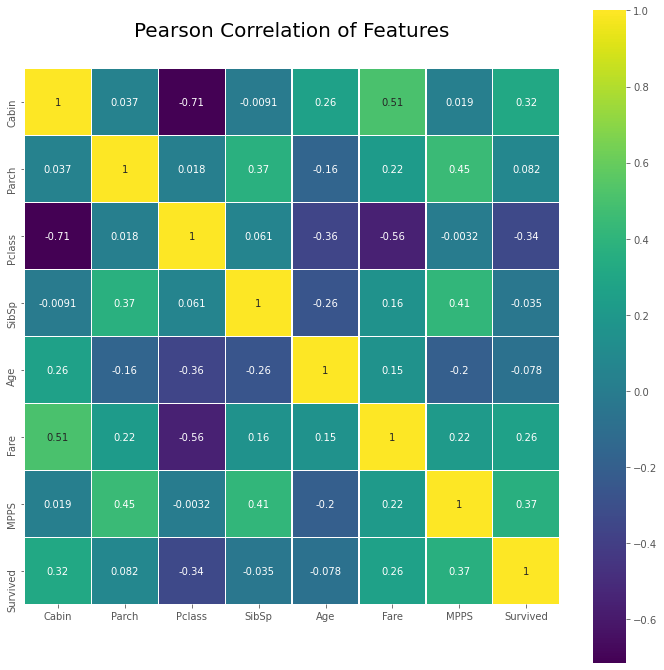

In [104]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(full[['Cabin','Parch','Pclass','SibSp','Age','Fare','MPPS','Survived']].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# 6- Hyperparameters Tuning
This step refers to hyperparameter tuning, which is an "artform" as opposed to a science
Tune model parameters for improved performance
Simple model hyperparameters may include: number of training steps, learning rate, initialization values and distribution, etc.

__Now let's do grid search for some algorithms. Since many algorithms performs better in scaled data, we will use scaled data.__

In [106]:
predictors=['Cabin','Embarked','Parch','Pclass','Sex','SibSp','Title','Age','Fare','MPPS']
full_dummies=pd.get_dummies(full[predictors])
X=full_dummies[:891]
y=full.Survived[:891]
test_X=full_dummies[891:]

scaler=StandardScaler()
X_scaled=scaler.fit(X).transform(X)
test_X_scaled=scaler.fit(X).transform(test_X)

In [107]:
from sklearn.model_selection import GridSearchCV

### k-Nearest Neighbors

In [108]:
param_grid={'n_neighbors':[1,2,3,4,5,6,7,8,9]}
grid_search=GridSearchCV(KNeighborsClassifier(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'n_neighbors': 8}, 0.8237775406440273)

### Logistic Regression

In [109]:
param_grid={'C':[0.01,0.1,1,10]}
grid_search=GridSearchCV(LogisticRegression(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'C': 0.1}, 0.8305128366078713)

In [110]:
# second round grid search
param_grid={'C':[0.04,0.06,0.08,0.1,0.12,0.14]}
grid_search=GridSearchCV(LogisticRegression(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'C': 0.1}, 0.8305128366078713)

### Support Vector Machine

In [111]:
param_grid={'C':[0.01,0.1,1,10],'gamma':[0.01,0.1,1,10]}
grid_search=GridSearchCV(SVC(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'C': 1, 'gamma': 0.01}, 0.82712949595129)

In [112]:
#second round grid search
param_grid={'C':[2,4,6,8,10,12,14],'gamma':[0.008,0.01,0.012,0.015,0.02]}
grid_search=GridSearchCV(SVC(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'C': 14, 'gamma': 0.015}, 0.832772581758835)

### Gradient Boosting Decision Tree

In [113]:
param_grid={'n_estimators':[30,50,80,120,200],'learning_rate':[0.05,0.1,0.5,1],'max_depth':[1,2,3,4,5]}
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 120},
 0.8439959826752872)

In [114]:
#second round search
param_grid={'n_estimators':[100,120,140,160],'learning_rate':[0.05,0.08,0.1,0.12],'max_depth':[3,4]}
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 160},
 0.8462431736865232)

# 7 - Make Predictions, Ensemble Methods 

Using further (test set) data which have, until this point, been withheld from the model (and for which class labels are known), are used to test the model; a better approximation of how the model will perform in the real world

## Bagging

__We use logistic regression with the parameter we just tuned to apply bagging.__

In [115]:
from sklearn.ensemble import BaggingClassifier

In [117]:
bagging=BaggingClassifier(LogisticRegression(C=0.06),n_estimators=100)

## VotingClassifier

__We use five models to apply votingclassifier, namely logistic regression, random forest, gradient boosting decision,support vector machine and k-nearest neighbors.__

In [118]:
from sklearn.ensemble import VotingClassifier

In [119]:
clf1=LogisticRegression(C=0.06)
clf2=RandomForestClassifier(n_estimators=500)
clf3=GradientBoostingClassifier(n_estimators=100,learning_rate=0.12,max_depth=4)
clf4=SVC(C=4,gamma=0.015,probability=True)
clf5=KNeighborsClassifier(n_neighbors=8)

In [120]:
eclf_hard=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)])

In [121]:
# add weights
eclfW_hard=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)],weights=[1,1,2,2,1])

In [123]:
# soft voting
eclf_soft=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)],voting='soft')

In [124]:
# add weights
eclfW_soft=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)],voting='soft',weights=[1,1,2,2,1])

__Finally we can evaluate all the models we just used.__

In [125]:
models=[KNeighborsClassifier(n_neighbors=8),LogisticRegression(C=0.06),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(n_estimators=500),
        GradientBoostingClassifier(n_estimators=100,learning_rate=0.12,max_depth=4),SVC(C=4,gamma=0.015),
        eclf_hard,eclf_soft,eclfW_hard,eclfW_soft,bagging]

In [126]:
names=['KNN','LR','NB','CART','RF','GBT','SVM','VC_hard','VC_soft','VCW_hard','VCW_soft','Bagging']
for name,model in zip(names,models):
    score=cross_val_score(model,X_scaled,y,cv=5)
    print("{}: {},{}".format(name,score.mean(),score))

KNN: 0.8237775406440273,[0.83798883 0.79775281 0.85393258 0.78651685 0.84269663]
LR: 0.8293955181721172,[0.83798883 0.82022472 0.80337079 0.80898876 0.87640449]
NB: 0.7429979285669448,[0.73184358 0.75842697 0.71910112 0.71348315 0.79213483]
CART: 0.7699516665620489,[0.74301676 0.76966292 0.79213483 0.73595506 0.80898876]
RF: 0.8069487163392128,[0.81564246 0.78089888 0.85393258 0.75280899 0.83146067]
GBT: 0.8395016006528152,[0.84357542 0.8258427  0.84831461 0.82022472 0.85955056]
SVM: 0.8304940053982801,[0.8603352  0.82022472 0.82022472 0.78651685 0.86516854]
VC_hard: 0.8361182599962337,[0.8547486  0.81460674 0.85393258 0.79775281 0.85955056]
VC_soft: 0.8293766869625261,[0.8547486  0.81460674 0.83146067 0.79213483 0.85393258]
VCW_hard: 0.8361182599962337,[0.8547486  0.81460674 0.85393258 0.79775281 0.85955056]
VCW_soft: 0.8316364321134895,[0.84357542 0.83146067 0.83146067 0.79213483 0.85955056]
Bagging: 0.828278199736363,[0.83240223 0.82022472 0.80337079 0.80898876 0.87640449]


We can select any model and predict